In [173]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import numpy as np
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, Dropout, Dense
from tensorflow.keras.metrics import Recall, AUC, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, BinaryAccuracy
from sklearn.metrics import confusion_matrix
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
import time

In [177]:
train_dir=r"D:\PROJECTS\20230719_Melanoma Classification\train"
test_dir=r"D:\PROJECTS\20230719_Melanoma Classification\test"
train_inspection_dir=r"D:\PROJECTS\20230719_Melanoma Classification\train_inspection_dir"
validation_inspection_dir=r"D:\PROJECTS\20230719_Melanoma Classification\validation_inspection_dir"
image_size=(224,224)
batch_size=32

In [178]:
#ImageDataGenerator for the train and validation sets

#data generator with data augmentation for the train set
train_gen_aug=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    brightness_range=[0.9, 1.1],
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='constant',
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    validation_split=0.2,
)

#data generator without data augmentation for the validation set
data_gen=ImageDataGenerator(
    rescale=1./255,     #scaling images to [0,1]
    validation_split=0.2,       #20% of data to be used for validation
)


#data generator without data augmentation for the test set
test_gen=ImageDataGenerator(
    rescale=1./255,
)


#Train Generator
train_generator=data_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=34,    #optional seed for loading the images in the same way each run
    save_to_dir=train_inspection_dir,
    subset='training'   #specifying this generator is for training
)

#Validation Generator
validation_generator=data_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=34,    #optional seed for loading the images in the same way each run
    save_to_dir=validation_inspection_dir,
    subset='validation'   #specifying this generator is for validation
)

#Test data generator
test_generator=data_gen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=56,    #optional seed for loading the images in the same way each run
)

Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


Found 2110 images belonging to 2 classes.


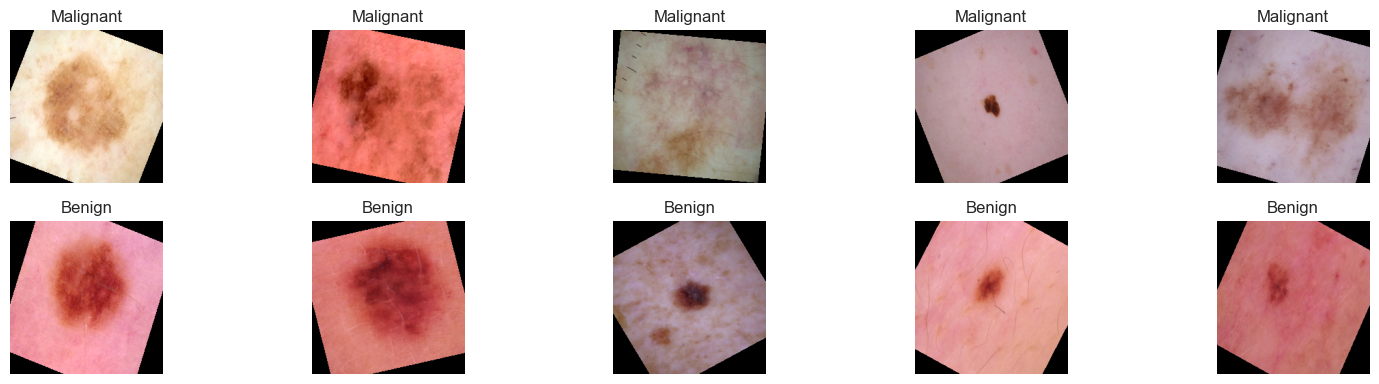

In [181]:
import matplotlib.pyplot as plt

# Get a few original images and labels from the train generator
malignant_images = []
benign_images = []
malignant_labels = []
benign_labels = []
num_images_per_class = 5

for i, (images, labels) in enumerate(train_gen_aug.flow_from_directory(train_dir, target_size=image_size, class_mode='binary', seed=34, subset='training', shuffle=True)):
    for image, label in zip(images, labels):
        if label == 0:  # Benign class
            if len(benign_images) < num_images_per_class:
                benign_images.append(image)
                benign_labels.append("Benign")
        else:  # Malignant class
            if len(malignant_images) < num_images_per_class:
                malignant_images.append(image)
                malignant_labels.append("Malignant")

    if len(benign_images) >= num_images_per_class and len(malignant_images) >= num_images_per_class:
        break

# Visualize the augmented images
fig, axes = plt.subplots(2, num_images_per_class, figsize=(16, 4))

# Plot malignant images and labels
for i, (image, label) in enumerate(zip(malignant_images, malignant_labels)):
    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[0, i].set_title(label)

# Plot benign images and labels
for i, (image, label) in enumerate(zip(benign_images, benign_labels)):
    axes[1, i].imshow(image)
    axes[1, i].axis('off')
    axes[1, i].set_title(label)

plt.tight_layout()
plt.show()


In [182]:
# Train Generator
train_batch = train_generator.next()
train_data_shape = train_batch[0].shape
train_label_shape = train_batch[1].shape

print("Train dataset:")
print("Data batch shape:", train_data_shape)
print("Label batch shape:", train_label_shape)

# Validation Generator
validation_batch = validation_generator.next()
validation_data_shape = validation_batch[0].shape
validation_label_shape = validation_batch[1].shape

print("Validation dataset:")
print("Data batch shape:", validation_data_shape)
print("Label batch shape:", validation_label_shape)

# Test Generator
test_batch = test_generator.next()
test_data_shape = test_batch[0].shape
test_label_shape = test_batch[1].shape

print("Test dataset:")
print("Data batch shape:", test_data_shape)
print("Label batch shape:", test_label_shape)


Train dataset:
Data batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Validation dataset:
Data batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Test dataset:
Data batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


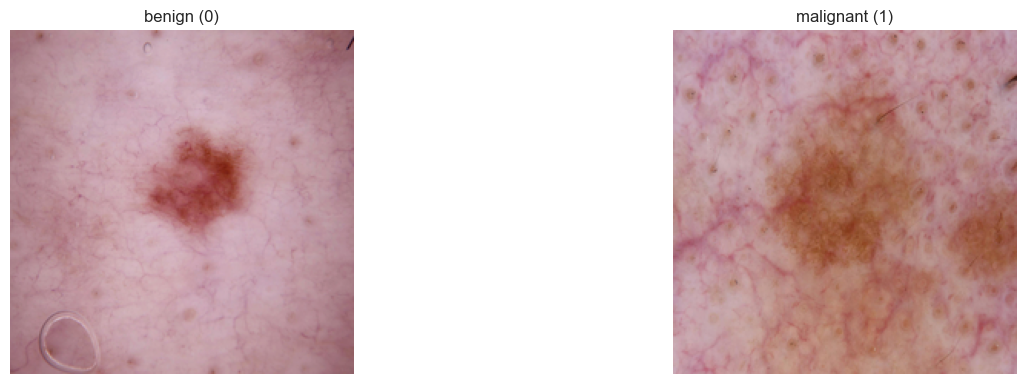

In [183]:
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
num_plots = min(num_classes, 4)  # Limit the number of classes to fit the available subplots

# Create subplots with one row and num_plots columns
fig, axs = plt.subplots(nrows=1, ncols=num_plots, figsize=(16, 4))

# Iterate over the class directories
for i in range(num_plots):
    class_name = class_names[i]
    class_dir = os.path.join(train_dir, class_name)

    # Find the first four images in the class directory
    image_files = os.listdir(class_dir)[:4]
    image_paths = [os.path.join(class_dir, image_file) for image_file in image_files]

    # Load and plot the images
    for j, image_path in enumerate(image_paths):
        image = Image.open(image_path)
        axs[i].imshow(image)
        axs[i].set_title(f"{class_name} ({i})")
        axs[i].axis('off')
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


In [185]:
# Get the number of samples in each class for the training set
train_class_counts = train_generator.classes
train_class_counts = np.bincount(train_class_counts)

# Get the number of samples in each class for the validation set
val_class_counts = validation_generator.classes
val_class_counts = np.bincount(val_class_counts)

# Get the number of samples in each class for the test set
test_class_counts = test_generator.classes
test_class_counts = np.bincount(test_class_counts)

# Define the class labels
class_labels = train_generator.class_indices

# Print the class counts for each dataset
print("Training Set Class Counts:")
for label, count in zip(class_labels, train_class_counts):
    print(label, ":", count)

print("\nValidation Set Class Counts:")
for label, count in zip(class_labels, val_class_counts):
    print(label, ":", count)

print("\nTest Set Class Counts:")
for label, count in zip(class_labels, test_class_counts):
    print(label, ":", count)


Training Set Class Counts:
benign : 1152
malignant : 958

Validation Set Class Counts:
benign : 288
malignant : 239

Test Set Class Counts:
benign : 360
malignant : 300


Initail bias

In [187]:
# Get class counts
counts=np.bincount(train_generator.classes) #counts the occurrences of each class in train_generator array
pos=counts[1] # +ve malignant
neg=counts[0]  # -ve benign

#Calculate correct initial output bias for faster convergence
output_bias=-np.log(pos/neg)
print("Initial output bias:", output_bias)
output_bias=tf.keras.initializers.Constant(output_bias)

Initial output bias: 0.18440706328497602


Callbacks

In [189]:
model_dir=r"D:\PROJECTS\20230719_Melanoma Classification\model_dir"
log_dir=r"D:\PROJECTS\20230719_Melanoma Classification\logs"

In [190]:
def callbacks(model_name, append_csv=False):
    callb = [
        ModelCheckpoint(
            filepath=model_dir + model_name,
            monitor='val_auc',
            save_best_only=True,
            mode='max' 
        ),
        EarlyStopping(
            monitor='val_auc',
            patience=10,
            mode='max',
            restore_best_weights=True,
        ),
        CSVLogger(
            filename=csv_dir + model_name + '.csv',
            separator=',',
            append=append_csv,
        ),
        TensorBoard(log_dir=log_dir)  
    ]
    return callb


Base Model 

In [193]:
def make_base_model(dropout=0.0):
    input_tensor = keras.Input(shape=(None, None, 3), name='input')

    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)  # Add dropout after the first convolutional layer

    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)  # Add dropout after the second convolutional layer

    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)  # Add dropout after the third convolutional layer

    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)  # Add dropout after the fourth convolutional layer

    x = layers.GlobalAveragePooling2D()(x)
    if dropout:
        x = Dropout(rate=dropout)(x)

    x = Dense(16, activation='relu')(x)
    output = Dense(1, activation='sigmoid', name='output', bias_initializer=output_bias)(x)    # specify output bias

    model = keras.Model(inputs=input_tensor, outputs=output, name='base_model')
    return model

model = make_base_model(dropout=0.0)
model.summary()


Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, None, 3)]   0         
                                                                 
 separable_conv2d (Separable  (None, None, None, 32)   155       
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, None, None, 32)    0         
                                                                 
 separable_conv2d_1 (Separab  (None, None, None, 64)   2400      
 leConv2D)                                                       
                                                        

Train Model

In [194]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy','AUC', 'Recall']
)

In [196]:
history=model.fit(
    train_generator,
    epochs=50,
    callbacks=callbacks('base_model'),
    validation_data=validation_generator,
    workers=2
    )

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.5460 - auc: 0.5661 - recall: 0.0000e+00

INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


66/66 [==============================] - 125s 2s/step - loss: 0.6848 - accuracy: 0.5460 - auc: 0.5661 - recall: 0.0000e+00 - val_loss: 0.6879 - val_accuracy: 0.5465 - val_auc: 0.6636 - val_recall: 0.0000e+00
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.5649 - auc: 0.6615 - recall: 0.0585

INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


66/66 [==============================] - 128s 2s/step - loss: 0.6726 - accuracy: 0.5649 - auc: 0.6615 - recall: 0.0585 - val_loss: 0.7037 - val_accuracy: 0.4535 - val_auc: 0.7506 - val_recall: 1.0000
Epoch 3/50
66/66 [==============================] - 127s 2s/step - loss: 0.6037 - accuracy: 0.6834 - auc: 0.7512 - recall: 0.5720 - val_loss: 0.7160 - val_accuracy: 0.4535 - val_auc: 0.5017 - val_recall: 1.0000
Epoch 4/50
66/66 [==============================] - 122s 2s/step - loss: 0.5629 - accuracy: 0.7308 - auc: 0.7745 - recall: 0.7453 - val_loss: 0.7384 - val_accuracy: 0.4535 - val_auc: 0.5000 - val_recall: 1.0000
Epoch 5/50
66/66 [==============================] - ETA: 0s - loss: 0.5078 - accuracy: 0.7569 - auc: 0.8026 - recall: 0.8079

INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


66/66 [==============================] - 123s 2s/step - loss: 0.5078 - accuracy: 0.7569 - auc: 0.8026 - recall: 0.8079 - val_loss: 0.7421 - val_accuracy: 0.4782 - val_auc: 0.7952 - val_recall: 1.0000
Epoch 6/50
66/66 [==============================] - ETA: 0s - loss: 0.4799 - accuracy: 0.7716 - auc: 0.8389 - recall: 0.8215

INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


66/66 [==============================] - 123s 2s/step - loss: 0.4799 - accuracy: 0.7716 - auc: 0.8389 - recall: 0.8215 - val_loss: 0.8552 - val_accuracy: 0.4535 - val_auc: 0.8065 - val_recall: 1.0000
Epoch 7/50
66/66 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.7948 - auc: 0.8605 - recall: 0.8549

INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


66/66 [==============================] - 122s 2s/step - loss: 0.4527 - accuracy: 0.7948 - auc: 0.8605 - recall: 0.8549 - val_loss: 0.8426 - val_accuracy: 0.4573 - val_auc: 0.8089 - val_recall: 1.0000
Epoch 8/50
66/66 [==============================] - 119s 2s/step - loss: 0.4505 - accuracy: 0.7839 - auc: 0.8651 - recall: 0.8330 - val_loss: 0.7571 - val_accuracy: 0.5218 - val_auc: 0.8043 - val_recall: 1.0000
Epoch 9/50
66/66 [==============================] - 120s 2s/step - loss: 0.4296 - accuracy: 0.7957 - auc: 0.8784 - recall: 0.8518 - val_loss: 0.7458 - val_accuracy: 0.4839 - val_auc: 0.8085 - val_recall: 1.0000
Epoch 10/50
66/66 [==============================] - ETA: 0s - loss: 0.4202 - accuracy: 0.7948 - auc: 0.8801 - recall: 0.8664

INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


66/66 [==============================] - 124s 2s/step - loss: 0.4202 - accuracy: 0.7948 - auc: 0.8801 - recall: 0.8664 - val_loss: 0.7529 - val_accuracy: 0.4915 - val_auc: 0.8125 - val_recall: 1.0000
Epoch 11/50
66/66 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.7991 - auc: 0.8856 - recall: 0.8674

INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


66/66 [==============================] - 125s 2s/step - loss: 0.4080 - accuracy: 0.7991 - auc: 0.8856 - recall: 0.8674 - val_loss: 0.8112 - val_accuracy: 0.4630 - val_auc: 0.8187 - val_recall: 1.0000
Epoch 12/50
66/66 [==============================] - 135s 2s/step - loss: 0.4035 - accuracy: 0.7938 - auc: 0.8880 - recall: 0.8894 - val_loss: 0.6578 - val_accuracy: 0.6414 - val_auc: 0.8140 - val_recall: 0.9958
Epoch 13/50
66/66 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.7986 - auc: 0.8903 - recall: 0.8653

INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


66/66 [==============================] - 128s 2s/step - loss: 0.3979 - accuracy: 0.7986 - auc: 0.8903 - recall: 0.8653 - val_loss: 0.6740 - val_accuracy: 0.6186 - val_auc: 0.8191 - val_recall: 1.0000
Epoch 14/50
66/66 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.8137 - auc: 0.8975 - recall: 0.9071

INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


66/66 [==============================] - 126s 2s/step - loss: 0.3900 - accuracy: 0.8137 - auc: 0.8975 - recall: 0.9071 - val_loss: 0.6935 - val_accuracy: 0.6262 - val_auc: 0.8200 - val_recall: 1.0000
Epoch 15/50
66/66 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.8090 - auc: 0.8960 - recall: 0.9050

INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


66/66 [==============================] - 170s 3s/step - loss: 0.3911 - accuracy: 0.8090 - auc: 0.8960 - recall: 0.9050 - val_loss: 0.7342 - val_accuracy: 0.5237 - val_auc: 0.8225 - val_recall: 1.0000
Epoch 16/50
66/66 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8109 - auc: 0.8981 - recall: 0.9102

INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


66/66 [==============================] - 162s 2s/step - loss: 0.3823 - accuracy: 0.8109 - auc: 0.8981 - recall: 0.9102 - val_loss: 0.6905 - val_accuracy: 0.5579 - val_auc: 0.8243 - val_recall: 1.0000
Epoch 17/50
66/66 [==============================] - 155s 2s/step - loss: 0.3902 - accuracy: 0.8085 - auc: 0.8955 - recall: 0.8789 - val_loss: 0.6422 - val_accuracy: 0.6414 - val_auc: 0.8116 - val_recall: 0.9958
Epoch 18/50
66/66 [==============================] - ETA: 0s - loss: 0.3775 - accuracy: 0.8152 - auc: 0.9021 - recall: 0.8883

INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


66/66 [==============================] - 143s 2s/step - loss: 0.3775 - accuracy: 0.8152 - auc: 0.9021 - recall: 0.8883 - val_loss: 0.6855 - val_accuracy: 0.6243 - val_auc: 0.8307 - val_recall: 1.0000
Epoch 19/50
66/66 [==============================] - 143s 2s/step - loss: 0.3834 - accuracy: 0.8123 - auc: 0.8982 - recall: 0.8883 - val_loss: 0.6702 - val_accuracy: 0.6300 - val_auc: 0.8229 - val_recall: 1.0000
Epoch 20/50
66/66 [==============================] - 144s 2s/step - loss: 0.3754 - accuracy: 0.8175 - auc: 0.9023 - recall: 0.9102 - val_loss: 0.6138 - val_accuracy: 0.6717 - val_auc: 0.8178 - val_recall: 0.9916
Epoch 21/50
66/66 [==============================] - 138s 2s/step - loss: 0.3855 - accuracy: 0.8100 - auc: 0.8979 - recall: 0.8653 - val_loss: 0.5736 - val_accuracy: 0.7362 - val_auc: 0.8200 - val_recall: 0.9707
Epoch 22/50
66/66 [==============================] - 137s 2s/step - loss: 0.3814 - accuracy: 0.8104 - auc: 0.8978 - recall: 0.8779 - val_loss: 0.5787 - val_accuracy

Visualizing Training

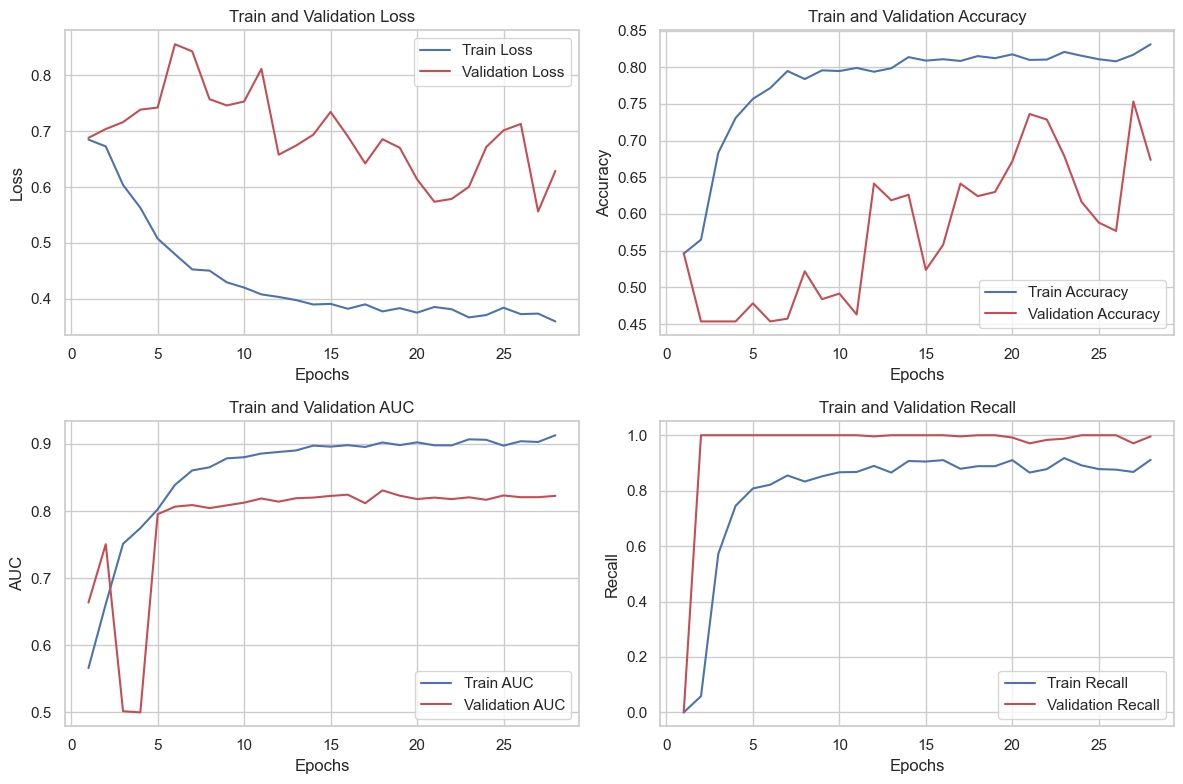

In [197]:
# Get the training metrics
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
train_auc = history.history['auc']
train_recall = history.history['recall']

# Get the validation metrics
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
val_auc = history.history['val_auc']
val_recall = history.history['val_recall']

# Plot the metrics
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_auc, 'b-', label='Train AUC')
plt.plot(epochs, val_auc, 'r-', label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Train and Validation AUC')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_recall, 'b-', label='Train Recall')
plt.plot(epochs, val_recall, 'r-', label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Train and Validation Recall')
plt.legend()

plt.tight_layout()
plt.show()


TensorBoard

In [198]:
tensorboard --logdir=<log_dir>

Reusing TensorBoard on port 6006 (pid 14788), started 10:30:09 ago. (Use '!kill 14788' to kill it.)

Confusion Matrix

21/21 [==============================] - 7s 310ms/step


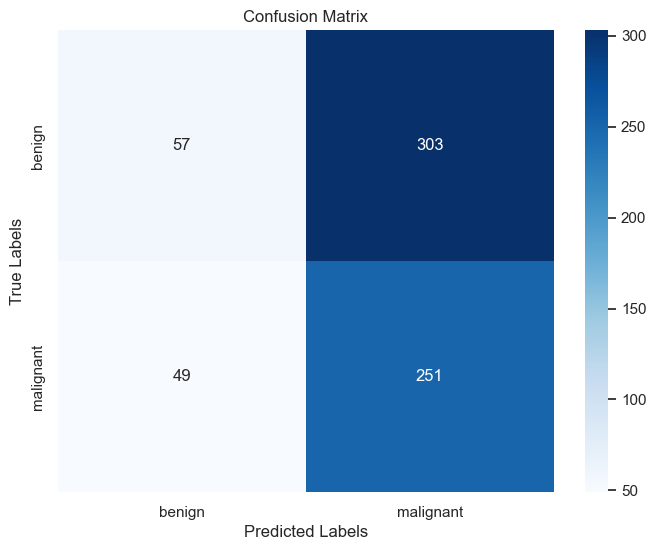

Malignant Tumors Detected (True Positives): 251
Benign Tumors Detected (True Negatives): 57
Malignant Tumors Missed (False Negatives): 49
Benign Tumors Misclassified (False Positives): 303
Accuracy: 0.4666666666666667
Precision: 0.45306859205776173
Recall: 0.8366666666666667
Specificity: 0.15833333333333333
F1 Score: 0.5878220140515223


In [199]:
# Make predictions on the test set
y_pred = model.predict(test_generator).flatten()
y_pred = np.where(y_pred >= 0.5, 1, 0)  # Apply threshold of 0.5

# Get the true labels from the test set generator
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = test_generator.class_indices

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = 2 * (precision * recall) / (precision + recall)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print additional metrics
print("Malignant Tumors Detected (True Positives):", tp)
print("Benign Tumors Detected (True Negatives):", tn)
print("Malignant Tumors Missed (False Negatives):", fn)
print("Benign Tumors Misclassified (False Positives):", fp)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)
print("F1 Score:", f1_score)


ROC & AUPRC

21/21 [==============================] - 6s 273ms/step


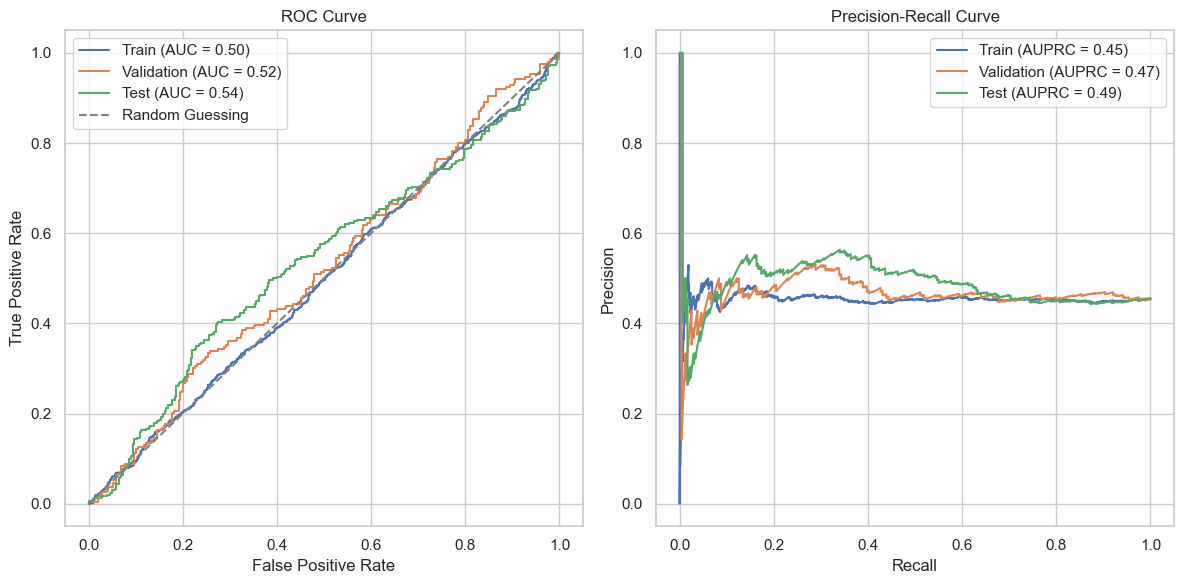

In [200]:
# Make predictions on the train, validation, and test sets
y_train_pred = model.predict(train_generator).flatten()
y_val_pred = model.predict(validation_generator).flatten()
y_test_pred = model.predict(test_generator).flatten()

# Get the true labels from the generator
y_train_true = train_generator.classes
y_val_true = validation_generator.classes
y_test_true = test_generator.classes

# Calculate the false positive rate, true positive rate, and threshold for ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_pred)
fpr_val, tpr_val, _ = roc_curve(y_val_true, y_val_pred)
fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_pred)

# Calculate the precision, recall, and threshold for precision-recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train_true, y_train_pred)
precision_val, recall_val, _ = precision_recall_curve(y_val_true, y_val_pred)
precision_test, recall_test, _ = precision_recall_curve(y_test_true, y_test_pred)

# Calculate AUC for ROC curve
auc_roc_train = roc_auc_score(y_train_true, y_train_pred)
auc_roc_val = roc_auc_score(y_val_true, y_val_pred)
auc_roc_test = roc_auc_score(y_test_true, y_test_pred)

# Calculate AUPRC (Area Under Precision-Recall Curve)
auc_pr_train = auc(recall_train, precision_train)
auc_pr_val = auc(recall_val, precision_val)
auc_pr_test = auc(recall_test, precision_test)

# Create subplots for ROC curve and Precision-Recall curve
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot ROC curve
axs[0].plot(fpr_train, tpr_train, label='Train (AUC = {:.2f})'.format(auc_roc_train))
axs[0].plot(fpr_val, tpr_val, label='Validation (AUC = {:.2f})'.format(auc_roc_val))
axs[0].plot(fpr_test, tpr_test, label='Test (AUC = {:.2f})'.format(auc_roc_test))
axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve')
axs[0].legend()
axs[0].grid(True)

# Plot Precision-Recall curve
axs[1].plot(recall_train, precision_train, label='Train (AUPRC = {:.2f})'.format(auc_pr_train))
axs[1].plot(recall_val, precision_val, label='Validation (AUPRC = {:.2f})'.format(auc_pr_val))
axs[1].plot(recall_test, precision_test, label='Test (AUPRC = {:.2f})'.format(auc_pr_test))
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend()
axs[1].grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

Training and Evaluating Multiple Baseline Models

In [201]:
METRICS = [
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'),
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc')
]


In [202]:
def train_and_evaluate_model_n_times(n_times, train_gen, valid_gen, test_gen, name, dropout=0.0, epochs=20):
    histories = []  # train and validation scores
    test_scores = []  # test_scores

    for i in range(n_times):
        print(f"Training model: {i+1} (out of {n_times} times)...")
        start = time.time()

        # instantiate new model
        model = make_base_model(dropout)
        # compile model
        model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

        # train it
        hist = model.fit(
            train_generator,
            epochs=epochs,
            callbacks=callbacks(name),
            validation_data=validation_generator,
            workers=2,
            verbose=0
        )

        # print out how long it took to train one model
        time_taken = time.gmtime(int(time.time() - start))
        print(f'Time taken: {time.strftime("%Hh %Mmin %Ss", time_taken)} ... Evaluating...')

        # load the best model and evaluate it on the test set
        best_model = keras.models.load_model(model_dir + name)
        test_score = best_model.evaluate(test_generator, return_dict=True)

        # store the results
        histories.append(hist.history)
        test_scores.append(test_score)

        # clear memory by releasing the global state
        tf.keras.backend.clear_session()

    # Convert the model to a concrete function
    concrete_func = tf.function(lambda x: model(x))
    concrete_func = concrete_func.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

    # Save the model with the concrete function
    tf.saved_model.save(model, model_dir, signatures=concrete_func)
    # save histories and test scores to file
    #pd.DataFrame(histories).to_csv(csv_dir + name + '_histories.csv', index=False)
    #pd.DataFrame(test_scores).to_csv(csv_dir + name + '_test_scores.csv', index=False)

    return histories, test_scores


def print_model_performance(scores, dset='test'):
    print(f"Average model performance on the {dset} set over {scores.shape[0]} runs:\n")
    for col in scores:
        mean = np.mean(scores[col].values)
        std = np.std(scores[col].values)
        print("{:<10} {:<5} (±{:.2f})".format(str(col + ':').capitalize(), np.round(mean, 2), std))


In [203]:
# Define the number of times to train and evaluate the model
n_times = 10

# Define the name of the model
model_name = 'base_model'

# Set the dropout rate and number of epochs
dropout = 0.2
epochs = 30

# Train and evaluate the model
histories, test_scores = train_and_evaluate_model_n_times(n_times, train_generator, validation_generator, test_generator, model_name, dropout, epochs)

# Convert the test scores to a DataFrame
test_scores_df = pd.DataFrame(test_scores)

# Print the average model performance on the test set
print_model_performance(test_scores_df)


Training model: 1 (out of 10 times)...


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


Time taken: 00h 33min 29s ... Evaluating...
21/21 [==============================] - 8s 342ms/step - loss: 0.7750 - tp: 300.0000 - fp: 328.0000 - tn: 32.0000 - fn: 0.0000e+00 - accuracy: 0.5030 - precision: 0.4777 - recall: 1.0000 - auc: 0.8103
Training model: 2 (out of 10 times)...


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


Time taken: 02h 06min 04s ... Evaluating...
21/21 [==============================] - 8s 340ms/step - loss: 0.4954 - tp: 294.0000 - fp: 146.0000 - tn: 214.0000 - fn: 6.0000 - accuracy: 0.7697 - precision: 0.6682 - recall: 0.9800 - auc: 0.8867
Training model: 3 (out of 10 times)...


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


Time taken: 01h 04min 50s ... Evaluating...
21/21 [==============================] - 8s 328ms/step - loss: 0.5392 - tp: 299.0000 - fp: 183.0000 - tn: 177.0000 - fn: 1.0000 - accuracy: 0.7212 - precision: 0.6203 - recall: 0.9967 - auc: 0.8912
Training model: 4 (out of 10 times)...


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


Time taken: 01h 04min 28s ... Evaluating...
21/21 [==============================] - 7s 282ms/step - loss: 0.7816 - tp: 300.0000 - fp: 357.0000 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 0.4591 - precision: 0.4566 - recall: 1.0000 - auc: 0.8972
Training model: 5 (out of 10 times)...


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


Time taken: 00h 34min 33s ... Evaluating...
21/21 [==============================] - 7s 284ms/step - loss: 0.7280 - tp: 300.0000 - fp: 323.0000 - tn: 37.0000 - fn: 0.0000e+00 - accuracy: 0.5106 - precision: 0.4815 - recall: 1.0000 - auc: 0.8874
Training model: 6 (out of 10 times)...


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


Time taken: 00h 36min 14s ... Evaluating...
21/21 [==============================] - 7s 286ms/step - loss: 0.7515 - tp: 300.0000 - fp: 326.0000 - tn: 34.0000 - fn: 0.0000e+00 - accuracy: 0.5061 - precision: 0.4792 - recall: 1.0000 - auc: 0.8749
Training model: 7 (out of 10 times)...


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


Time taken: 00h 36min 20s ... Evaluating...
21/21 [==============================] - 7s 300ms/step - loss: 0.9360 - tp: 300.0000 - fp: 356.0000 - tn: 4.0000 - fn: 0.0000e+00 - accuracy: 0.4606 - precision: 0.4573 - recall: 1.0000 - auc: 0.8391
Training model: 8 (out of 10 times)...


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


Time taken: 00h 31min 03s ... Evaluating...
21/21 [==============================] - 7s 298ms/step - loss: 0.6779 - tp: 300.0000 - fp: 261.0000 - tn: 99.0000 - fn: 0.0000e+00 - accuracy: 0.6045 - precision: 0.5348 - recall: 1.0000 - auc: 0.8779
Training model: 9 (out of 10 times)...


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


Time taken: 00h 54min 47s ... Evaluating...
21/21 [==============================] - 7s 289ms/step - loss: 0.5078 - tp: 299.0000 - fp: 167.0000 - tn: 193.0000 - fn: 1.0000 - accuracy: 0.7455 - precision: 0.6416 - recall: 0.9967 - auc: 0.8851
Training model: 10 (out of 10 times)...


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dirbase_model\assets


Time taken: 01h 01min 49s ... Evaluating...
21/21 [==============================] - 15s 647ms/step - loss: 0.6231 - tp: 299.0000 - fp: 225.0000 - tn: 135.0000 - fn: 1.0000 - accuracy: 0.6576 - precision: 0.5706 - recall: 0.9967 - auc: 0.8917


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dir\assets


INFO:tensorflow:Assets written to: D:\PROJECTS\20230719_Melanoma Classification\model_dir\assets


Average model performance on the test set over 10 runs:

Loss:      0.68  (±0.13)
Tp:        299.1 (±1.76)
Fp:        267.2 (±77.37)
Tn:        92.8  (±77.37)
Fn:        0.9   (±1.76)
Accuracy:  0.59  (±0.12)
Precision: 0.54  (±0.08)
Recall:    1.0   (±0.01)
Auc:       0.87  (±0.03)


## Transfer Learning

Loading Xception convolutional base

In [206]:
# instantiate the xception convolutional base
conv_base=keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(None, None, 3)
)

conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

Adding a classifier on top of the convolutional base

In [208]:
# Add a densely connected classifier on top of the convolutional base
input_tensor = keras.Input(shape=image_size+(3,), name='input')
x = conv_base(input_tensor)
x = layers.Flatten()(x)
x = Dense(16, activation='relu')(x)
output = Dense(1, activation='sigmoid', name='output',
               bias_initializer=output_bias)(x)

model = keras.Model(inputs=input_tensor, outputs=output, name='Xception_1')

Freeze convolutional base

In [209]:
print("Number of trainable parameters BEFORE freezing the conv base:", len(model.trainable_weights))

# Freeze the conv base
conv_base.trainable = False
print("Number of trainable parameters AFTER freezing the conv base:", len(model.trainable_weights))


Number of trainable parameters BEFORE freezing the conv base: 158
Number of trainable parameters AFTER freezing the conv base: 4


In [210]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy','AUC', 'Recall']
)

Training Model

In [211]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_auc', patience=10, mode='max', verbose=1)

# Assuming you have defined the model and compiled it before this point
history = model.fit(
    train_generator,
    epochs=100,  # Train for 100 epochs
    callbacks=[early_stopping],  # Use EarlyStopping callback
    validation_data=validation_generator,
    workers=2
)


Epoch 1/100
66/66 [==============================] - 285s 4s/step - loss: 0.5393 - accuracy: 0.7483 - auc: 0.8293 - recall: 0.8549 - val_loss: 0.6233 - val_accuracy: 0.7590 - val_auc: 0.8611 - val_recall: 0.6276
Epoch 2/100
66/66 [==============================] - 288s 4s/step - loss: 0.3405 - accuracy: 0.8308 - auc: 0.9270 - recall: 0.9029 - val_loss: 0.6007 - val_accuracy: 0.7780 - val_auc: 0.8651 - val_recall: 0.6653
Epoch 3/100
66/66 [==============================] - 271s 4s/step - loss: 0.2466 - accuracy: 0.8701 - auc: 0.9604 - recall: 0.9217 - val_loss: 0.4832 - val_accuracy: 0.7837 - val_auc: 0.8851 - val_recall: 0.7406
Epoch 4/100
66/66 [==============================] - 265s 4s/step - loss: 0.2085 - accuracy: 0.8924 - auc: 0.9720 - recall: 0.9144 - val_loss: 0.4635 - val_accuracy: 0.8083 - val_auc: 0.8992 - val_recall: 0.7782
Epoch 5/100
66/66 [==============================] - 269s 4s/step - loss: 0.1560 - accuracy: 0.9318 - auc: 0.9853 - recall: 0.9259 - val_loss: 0.5840 - 

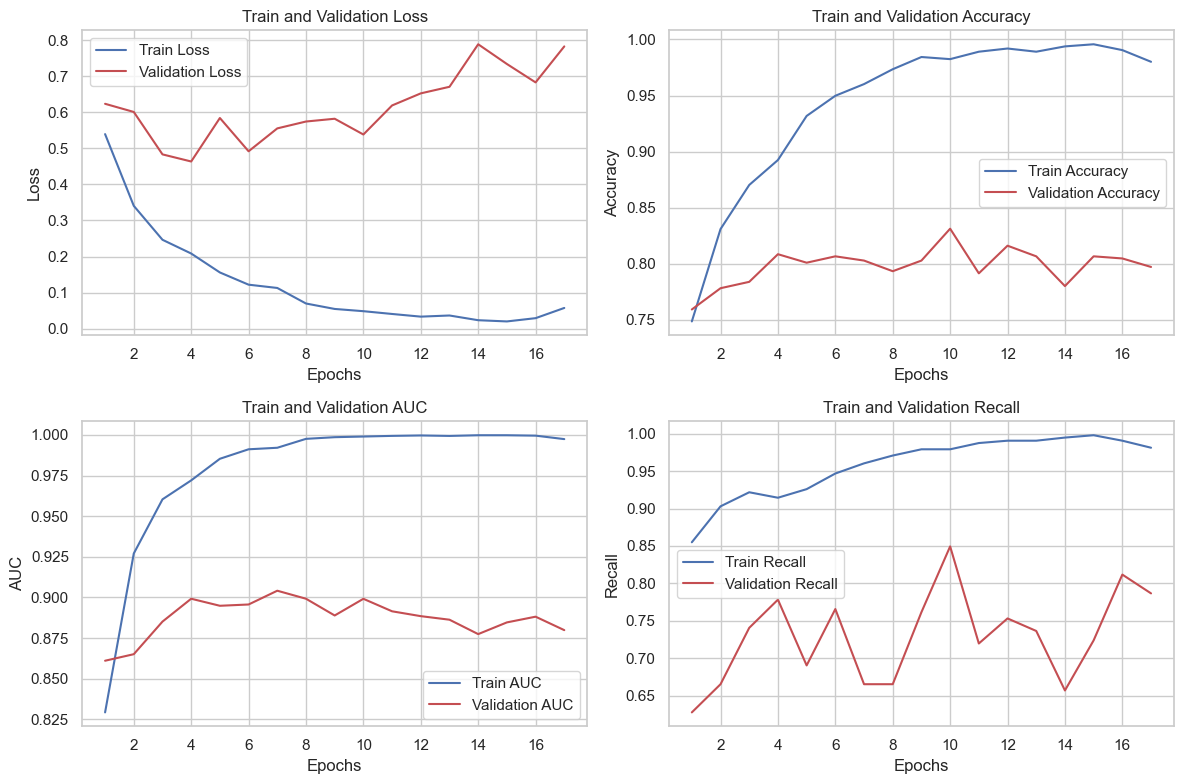

In [212]:
# Get the training metrics
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
train_auc = history.history['auc']
train_recall = history.history['recall']

# Get the validation metrics
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
val_auc = history.history['val_auc']
val_recall = history.history['val_recall']

# Plot the metrics
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_auc, 'b-', label='Train AUC')
plt.plot(epochs, val_auc, 'r-', label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Train and Validation AUC')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_recall, 'b-', label='Train Recall')
plt.plot(epochs, val_recall, 'r-', label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Train and Validation Recall')
plt.legend()

plt.tight_layout()
plt.show()